In [1]:
from cube import Cube
from tile import Tile
from ck2map import CK2Map
import continent_gen
import random
from border_doodler import BorderDoodler
import matplotlib.pyplot as plt
import numpy as np
from math import sqrt

In [18]:
def make_capital_county(c_size=5, coastal=True, shuffle=True, rgb=(255,255,255)):
    '''Makes a county where all provinces neighbor the central province.'''
    a = Tile(rgb=rgb)
    cube_list = list(Cube(0,0,0).neighbors())
    if shuffle:
        random.shuffle(cube_list)
    if coastal and c_size<7:
        a.water_list.append(cube_list[c_size-1])
    cube_list = cube_list[:c_size-1]
    for el in cube_list:
        a.add_hex(el)
    return a
        

def make_capital_duchy(origin=Cube(0,0,0), size_list=[5,4,4,4,4], coastal=True, shuffle=True):
    '''Makes a duchy where all provinces neighbor the central province.
    If coastal=True and d_size<7, one water hex bordering the capital will be included.
    To make a fidget spinner, use d_size=4 and shuffle=False.'''
    duchy = Tile(origin=origin, tile_list=[make_capital_county(c_size=size_list[0], coastal=coastal, shuffle=shuffle, rgb=random_c_cols.pop())],
                 hex_list=[], rgb=random_d_cols.pop())
    for el in size_list[1:]:
        duchy.add_new_tile(el, rgb = random_c_cols.pop())
    if coastal:
        drhl = duchy.real_hex_list()
        if continent_gen.check_water_access(drhl, duchy.real_water_list(), max([el.mag() for el in drhl])):
            return duchy
        else:
            return make_capital_duchy(origin, size_list, coastal, shuffle)
    else:
        return duchy

def make_kingdom(origin=Cube(0,0,0), size_list = [[5,4,4,4,4], [4,4,3,3], [4,4,3,3], [4,4,3]], coastal=True, shuffle=True,):
    kingdom = Tile(origin=origin, tile_list=[make_capital_duchy(size_list=size_list[0], coastal=coastal, shuffle=shuffle)], hex_list=[], rgb=random_k_cols.pop())
    size_list_index = 1
    while size_list_index < len(size_list):
        duchy_size_list = size_list[size_list_index]
        krhl = kingdom.relative_hex_list()
        krwl = kingdom.relative_water_list()
        new_county = Tile.new_tile(duchy_size_list[0], rgb=random_c_cols.pop())
        if new_county.move_into_place([kingdom.relative_neighbors()], krhl, krwl):
            new_duchy = Tile(origin=Cube(0,0,0), tile_list = [new_county], hex_list=[], rgb=random_d_cols.pop())
            for county_size_list in duchy_size_list[1:]:
                new_duchy.add_new_tile(county_size_list, cant=krhl + krwl, rgb=random_c_cols.pop())
            if continent_gen.check_water_access(krhl + new_duchy.relative_hex_list(), krwl, max([el.mag() for el in krhl])):
                kingdom.add_tile(new_duchy)
                size_list_index += 1
    return kingdom

In [19]:
cc = make_capital_county(5)
cc.rgb=(192,192,0)
cd = Tile(hex_list=[],tile_list=[cc], rgb=(255,0,0))

In [12]:
random_k_cols = [(np.random.randint(128, 256), 64, 64) for _ in range(300)]
random_d_cols = [(64,np.random.randint(128, 256), 64) for _ in range(300)]
random_c_cols = [(np.random.randint(64, 256),64,np.random.randint(64, 256)) for _ in range(300)]

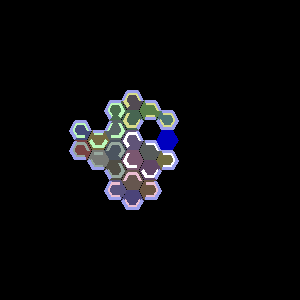

In [21]:
cd = make_capital_duchy()
bd = BorderDoodler(cd, size=(300,300))
bd.im

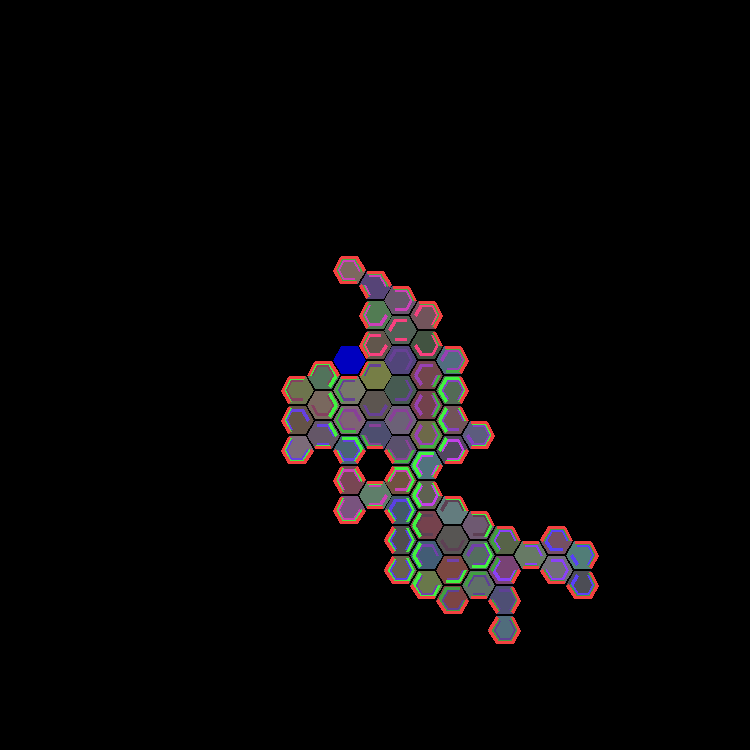

In [24]:
kingdom = make_kingdom()
bdk = BorderDoodler(kingdom, size=(750,750),radius=15)
bdk.im

In [9]:
len(random_cols)

288

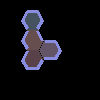

In [32]:
duchy_size_list = [4,4,3,3]
krhl = kingdom.relative_hex_list()
new_county = Tile.new_tile(duchy_size_list[0], rgb=random_cols.pop())
bdc = BorderDoodler(new_county)
bdc.im

In [34]:
print(new_county.origin)
print(new_county.move_into_place([kingdom.relative_neighbors()], kingdom.relative_hex_list(),kingdom.relative_water_list(),))
print(new_county.origin)

0, 0, 0
True
-4, 4, 0


In [ ]:
        if new_county.move_into_place([kingdom.neighbors()], kingdom.relative_hex_list(),kingdom.relative_water_list(),):
            new_duchy = Tile(origin=Cube(0,0,0), tile_list = [new_county], hex_list=[], rgb=random_cols.pop())
            for county_size_list in duchy_size_list:
                new_duchy.add_new_tile(county_size_list, cant=krhl)
            kingdom.add_tile(new_duchy)
        else:
            print('Failed to add duchy!')

In [26]:
coastal = True
shuffle = True
duchy = Tile(origin=origin, tile_list=[make_capital_county(c_size=size_list[0][0], coastal=coastal, shuffle=shuffle)],
                 hex_list=[])

In [5]:
from PIL import Image, ImageDraw
size = (100,100)
im = Image.new('RGB', size, (0,0,0))
draw = ImageDraw.Draw(im)
radius = 10

def get_center(cube):
    assert cube.x + cube.y + cube.z == 0, f'bad cube {cube}'
    p = np.array(size) / 2
    p += cube.x * np.array([sqrt(3), -1]) * radius
    p += cube.y * np.array([0, -1]) * radius * 2
    return p

def get_hex_points(p, r=0):
    points = []
    for angle in range(0, 360, 60):
        theta = angle * np.pi / 180
        delta = np.array([np.cos(theta), np.sin(theta)]) * (radius+1-r)
        points.append(tuple(p + delta))
    return points

In [12]:
for nind, nbor in enumerate(Cube().ordered_neighbors()):
    hex_points = get_hex_points(get_center(nbor))
    # draw.polygon(hex_points, outline=(40+nind*10,0,0), fill=(nind*40,0,0))
    hex_points.append(hex_points[0])  # Wraparound.
    for ind in range(6):
        draw.line((hex_points[ind], hex_points[ind+1]),
        fill=(80+ind*20,0,0))

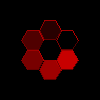

In [13]:
im

In [8]:
get_hex_points(get_center(Cube()))

[(61.0, 50.0),
 (55.5, 59.52627944162882),
 (44.5, 59.52627944162883),
 (39.0, 50.0),
 (44.49999999999999, 40.47372055837118),
 (55.5, 40.47372055837118)]

In [ ]:
for cube in cc.real_hex_list():
    center_pixel = 

In [22]:

origin=Cube(0,0,0)
size_list = [[5,4,4,4,4], [4,4,3,3], [4,4,3,3], [4,4,3]]
kingdom = Tile(origin=origin, tile_list=[make_capital_duchy(size_list=size_list[0])], hex_list=[])
kingdom.doodle()

AttributeError: 'NoneType' object has no attribute 'real_hex_list'

In [1]:
from math import sqrt
from PIL import Image, ImageDraw

In [ ]:
class TitleDoodler:
    def __init__(self, size=(500,500), radius=15):
        self.im = Image.new('RGB', size, (0, 0, 0))
        self.draw = ImageDraw.Draw(self.im)
        self.size = size
        self.radius = radius

    def get_center(self, cube):
        assert cube.x + cube.y + cube.z == 0, f'bad cube {cube}'
        p = np.array(self.size) / 2
        p += cube.x * np.array([sqrt(3), -1]) * self.radius
        p += cube.y * np.array([0, -1]) * self.radius * 2
        return p

    def get_hex_points(self, p, radius=None):
        radius = radius or self.radius
        points = []
        for angle in range(0, 360, 60):
            theta = angle * np.pi / 180
            delta = np.array([np.cos(theta), np.sin(theta)]) * radius
            points.append(tuple(p + delta))
        return points

    def draw_barony(self, cube, color):
        '''Return the '''
        self.draw.polygon(self.get_hex_points(self.get_center(cube)), fill=color)
        